In [1]:
import json
import csv
import pandas as pd
import numpy as np 

from igraph import *
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
from scipy.spatial import distance



In [2]:
dir_path="data/"

In [3]:
json_filename = 'los_angeles_censustracts.json'
json_df =pd.read_json(dir_path+json_filename, orient='records')


In [4]:
#get uber data from gcc file
uber_dec = np.loadtxt(dir_path + '/uber_dec.txt')
uber_gcc_graph = {}
for row in uber_dec:
    location_index = tuple(np.sort(row[0:2]).astype('int'))
    uber_gcc_graph[location_index] = row[2]
    
uber_gcc_ids = np.concatenate([uber_dec[:,0],uber_dec[:,1]])
uber_gcc_ids = np.unique(uber_gcc_ids).astype('int')


In [5]:
#create dataframe for easier use
src=[ids[0] for ids in [*uber_gcc_graph]]
dst=[ids[1] for ids in [*uber_gcc_graph]]
trvl_tm = list(uber_gcc_graph.values())
uber_dec_data = {'sourceid': src, 
          'dstid': dst,
          'mean_travel_time':trvl_tm}
uber_dec_df = pd.DataFrame.from_dict(uber_dec_data)

In [6]:
uber_dec_df.head(3)

,sourceid,dstid,mean_travel_time
0,669,1638,1284.57
1,822,1620,2174.85
2,1707,1994,679.35


In [7]:
# create dataframe with all feature information organized into columns
geo_df = pd.DataFrame()
for feature in json_df['features']:
    new_row_prop = feature['properties']
    new_row_geo = feature['geometry']
    new_row_prop.update(new_row_geo)
#     print(new_row_geo)
    geo_df = geo_df.append(pd.DataFrame.from_dict([new_row_prop], orient='columns'), ignore_index=True)


In [8]:
# geo_df.head()

In [9]:
def find_mean_coordinate_polygon(coor_ser):
#     coor_arr = np.array(coor_ser[0][0]) #get the array of coordinates from the series
    mean_coord = np.mean(np.asarray(coor_ser[0]),axis=0)
    return [round(mean_coord[0],2), round(mean_coord[1],2)]

def find_mean_coordinate_multi(coor_ser):
    lat_arr = []
    long_arr = []
    for pol in coor_ser:
        mean_coor = find_mean_coordinate_polygon(pol)
        lat_arr.append(mean_coor[0])
        long_arr.append(mean_coor[1])
    result = np.mean((lat_arr, long_arr),axis=1)
    return [round(result[0],2), round(result[1],2)]

In [10]:
#get mean coordinates of polygons
poly_df = geo_df[geo_df.type=="Polygon"]
poly_mean = poly_df["coordinates"].apply(find_mean_coordinate_polygon)

#get mean coordinates of multipolygon
mpoly_df = geo_df[geo_df.type=="MultiPolygon"]
mpoly_mean = mpoly_df["coordinates"].apply(find_mean_coordinate_multi)

df = mpoly_mean.append(poly_mean)
mean_coordinates = df.sort_index()

#add mean_coordinate column to dataframe
geo_df["mean_coordinate"] = mean_coordinates
geo_df["mean_coordinate"]  = geo_df["mean_coordinate"].apply(lambda x: np.array(x))

#trim dataframe to keep only columns we need
geo_trim_df = geo_df.drop(['TRACT','coordinates', 'type', 'DISPLAY_NAME'], axis=1)
geo_trim_df.head(2)

,MOVEMENT_ID,mean_coordinate
0,1,"[-118.12, 34.1]"
1,2,"[-118.14, 34.1]"


In [11]:
def find_closest_id(coor_list, long, lat):
    arr = []
    for item in coor_list:
        arr.append(item)
        
    return np.argmin(distance.cdist(arr, [[long,lat]], 'euclidean'))


In [12]:
src = [34.04 , -118.56]   #1521 (for now?)  #TODO: Check this?
dest = [33.77 , -118.18]  #671


dest_id = find_closest_id(geo_trim_df["mean_coordinate"] , dest[1],dest[0])
src_id = find_closest_id(geo_trim_df["mean_coordinate"] , src[1], src[0])

print("source id: ", src_id)
print("dest id: ", dest_id)

source id:  1522
dest id:  671


In [13]:
malibu_coor = geo_trim_df.iloc[src_id].mean_coordinate
# malibu_coor[0]

long_beach_coor = geo_trim_df.iloc[dest_id].mean_coordinate


## Question 11
    Plot the road mesh that you obtain and explain the result. Create a graph G∆ whose nodes are different locations and its edges are produced by triangulation.

In [14]:
from scipy.spatial import Delaunay


In [15]:
#TODO: clean-up
#  geo_trim_df.head()
#  geo_trim_df.set_index('MOVEMENT_ID').to_dict()
move_id = np.array(geo_trim_df.MOVEMENT_ID)
mean_coor_col = np.array(geo_trim_df.mean_coordinate)
# location_dict={move_id:mean_coor_col}
# move_id

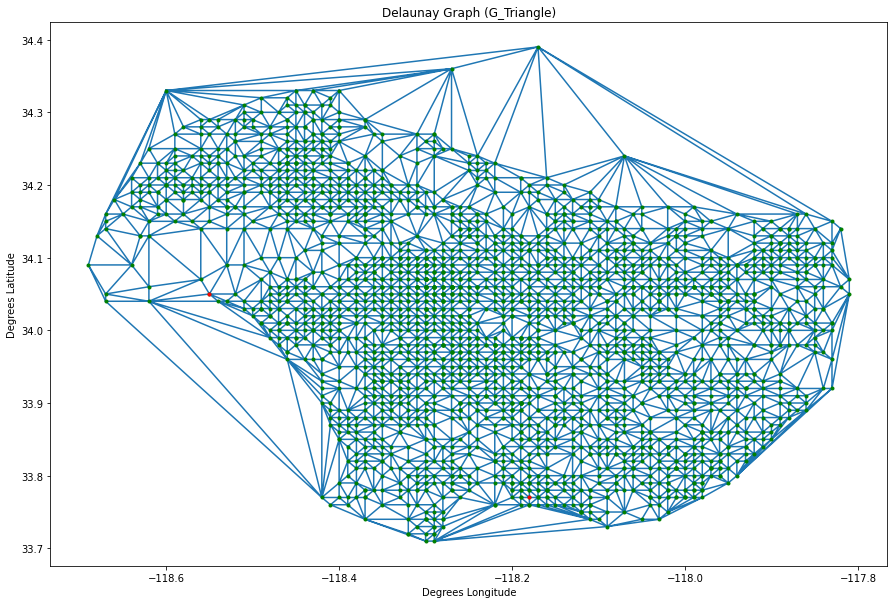

In [16]:
mean_coor_tst= np.zeros((len(uber_gcc_ids),2))
for n,location_key in enumerate(uber_gcc_ids):
#     mean_coor_tst[n]= str(location_key)
    coor = geo_trim_df[geo_trim_df.MOVEMENT_ID == str(location_key)]['mean_coordinate'].iloc[0]
    mean_coor_tst[n,:] = coor
#     print("coor: ", coor)

plt.figure(figsize=(15,10))

mean_coords = mean_coor_tst
tri = Delaunay(mean_coords)
plt.triplot(mean_coords[:,0], mean_coords[:,1], tri.simplices.copy())
plt.plot(mean_coords[:,0], mean_coords[:,1],'g.')
plt.plot(malibu_coor[0], malibu_coor[1], 'r.')
plt.plot(long_beach_coor[0], long_beach_coor[1], 'r.')

plt.xlabel('Degrees Longitude')
plt.ylabel('Degrees Latitude')
plt.title('Delaunay Graph (G_Triangle)')
plt.show()

# Question 12
    In report

# Question 13
    Calculate the maximum number of cars that can commute per hour from Malibu to Long Beach. Also calculate the number of edge-disjoint paths between the two spots. Does the number of edge-disjoint paths match what you see on your road map?
    Source coordinates: [34.04, -118.56]
    Destination coordinates: [33.77, -118.18]

In [17]:
# uber_dec_df[uber_dec_df.sourceid==1522]

In [18]:

def get_dist_miles(loc1, loc2):
    MILES_PER_DEGREE = 69
    
    coor1 = geo_trim_df.iloc[loc1-1].mean_coordinate
    coor2 = geo_trim_df.iloc[loc2-1].mean_coordinate
    dist_latlong = np.sqrt(np.sum(np.square(coor2-coor1)))
    
    return MILES_PER_DEGREE * dist_latlong

       



In [19]:
def get_travel_time( loc1, loc2):
    df = uber_dec_df
    #get mean travel time b/w loc1 and loc2 from LA dataframe
    exp = (df.sourceid== loc1) & (df.dstid== loc2)
    travel_time =  df[exp].mean_travel_time
    if (len(travel_time) <= 0):
        return 0    
    return travel_time.iloc[0]
    
def get_flow( loc1, loc2):
    travel_time_hr =  get_travel_time( loc1, loc2)/3600
    if(travel_time_hr > 0):
        #get distance from geo_df dataframe
        dist_miles = get_dist_miles(loc1, loc2)

        #calculate speed
        speed_mph = dist_miles / travel_time_hr

        #calculate flow (cars/hr)
        flow = (2*speed_mph) / (0.003 + (speed_mph/1800))

        return flow   
    else:
        return 0
    
def add_edge(graph, triangle, indx1, indx2):
    edge_new = tuple(sorted((triangle[indx1], triangle[indx2])))
    flow_new = get_flow(edge_new[0], edge_new[1])
#     print('(',edge_new[0], " ", edge_new[1], '): ', flow_new)

    if edge_new not in graph and flow_new > 0:
        graph[edge_new] = flow_new

def add_triangle_edges(graph, triangle):
    #get each edge as tuple (vertex1, vertex2)
    add_edge(graph, triangle, 0, 1)
    add_edge(graph, triangle, 1, 2)
    add_edge(graph, triangle, 2, 0)


In [20]:
# uber_dec_df

In [21]:
%%time
graph_triangled = {}

for i, id_indx in enumerate(tri.simplices):
    triangle = [uber_gcc_ids[id_indx[0]], uber_gcc_ids[id_indx[1]], uber_gcc_ids[id_indx[2]]]
    
    add_triangle_edges(graph_triangled, triangle)
    if(i%500 ==0 ):
        print(i, " of ", len(tri.simplices))


0  of  3691
500  of  3691
1000  of  3691
1500  of  3691
2000  of  3691
2500  of  3691
3000  of  3691
3500  of  3691
CPU times: user 28.4 s, sys: 1.81 s, total: 30.2 s
Wall time: 30.3 s


In [22]:
len(graph_triangled)

5422

In [23]:
#write to txt file in case we want to use R

with open(dir_path +'/g_triangled_orig.txt','w') as file:
    for edge in graph_triangled:
        edge_str = '{} {} {:.2f}\n'.format(int(edge[0]), int(edge[1]), graph_triangled[edge])
        file.write(edge_str)

In [24]:
def get_mean_coordinate(move_id):
    return list(geo_trim_df[geo_trim_df.MOVEMENT_ID== move_id]['mean_coordinate'])[0]
#     return list(geo_trim_df[geo_trim_df.MOVEMENT_ID== str(int(move_id))]['mean_coordinate'])[0]

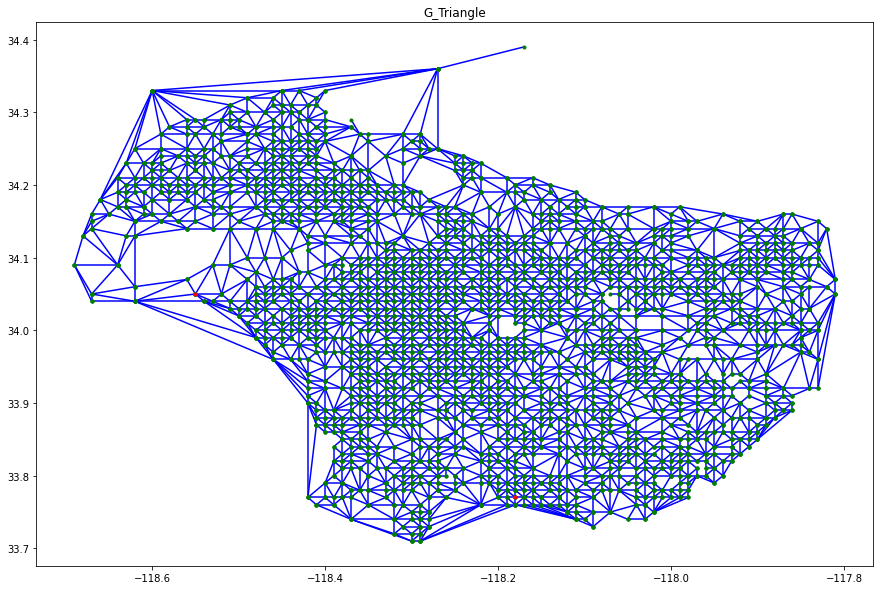

In [25]:
plt.figure(figsize=(15,10))
points=[]
for edges in graph_triangled.keys():
    coords1 = get_mean_coordinate(str(edges[0]))
    coords2 = get_mean_coordinate(str(edges[1]))
    points.append(coords1)
    points.append(coords2)
    plt.plot([coords1[0],coords2[0]],[coords1[1],coords2[1]],color='b')
points_thresh_arr = np.array(points)  
plt.plot(points_thresh_arr[:,0], points_thresh_arr[:,1], 'g.')

plt.plot(malibu_coor[0], malibu_coor[1], 'r.')
plt.plot(long_beach_coor[0], long_beach_coor[1], 'r.')
plt.title('G_Triangle')
plt.show()


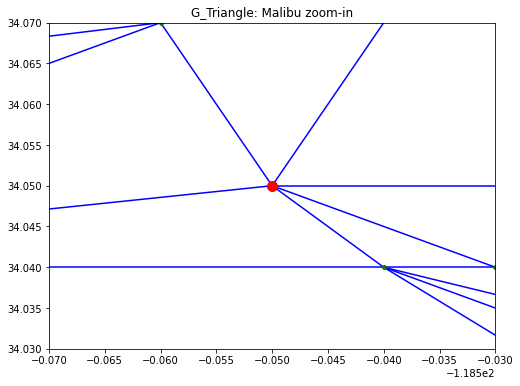

In [26]:
plt.figure(figsize=(8,6))
points=[]
for edges in graph_triangled.keys():
    coords1 = get_mean_coordinate(str(edges[0]))
    coords2 = get_mean_coordinate(str(edges[1]))
    points.append(coords1)
    points.append(coords2)
    plt.plot([coords1[0],coords2[0]],[coords1[1],coords2[1]],color='b')

points_tri_arr = np.array(points)  
plt.plot(points_tri_arr[:,0], points_tri_arr[:,1], 'g.')

plt.plot(malibu_coor[0], malibu_coor[1], 'r.', ms=20)
plt.plot(long_beach_coor[0], long_beach_coor[1], 'r.', ms=20)

plt.xlim(malibu_coor[0]-0.02, malibu_coor[0]+0.02)
plt.ylim(malibu_coor[1]-0.02, malibu_coor[1]+0.02)
plt.title('G_Triangle: Malibu zoom-in')

plt.show()


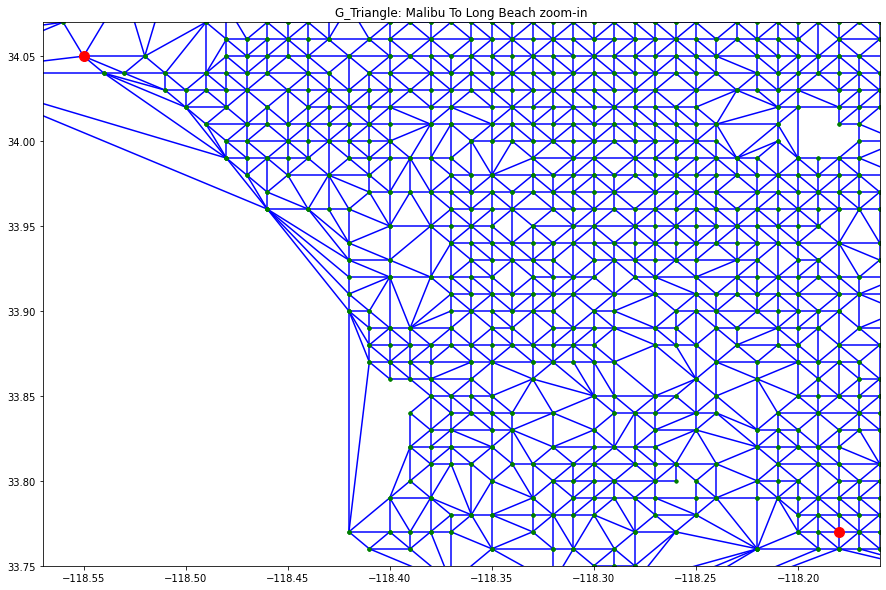

In [27]:
plt.figure(figsize=(15,10))
points=[]
for edges in graph_triangled.keys():
    coords1 = get_mean_coordinate(str(edges[0]))
    coords2 = get_mean_coordinate(str(edges[1]))
    points.append(coords1)
    points.append(coords2)
    plt.plot([coords1[0],coords2[0]],[coords1[1],coords2[1]],color='b')

points_tri_arr = np.array(points)  
plt.plot(points_tri_arr[:,0], points_tri_arr[:,1], 'g.')

plt.plot(malibu_coor[0], malibu_coor[1], 'r.', ms=20)
plt.plot(long_beach_coor[0], long_beach_coor[1], 'r.', ms=20)

plt.xlim(malibu_coor[0]-0.02, long_beach_coor[0]+0.02)
plt.ylim(long_beach_coor[1]-0.02, malibu_coor[1]+0.02)
plt.title('G_Triangle: Malibu To Long Beach zoom-in')

plt.show()


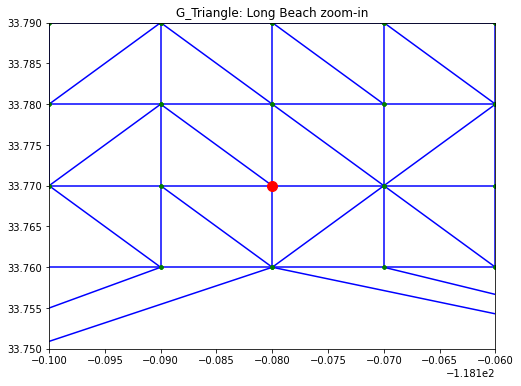

In [28]:
plt.figure(figsize=(8,6))
points=[]
for edges in graph_triangled.keys():
    coords1 = get_mean_coordinate(str(edges[0]))
    coords2 = get_mean_coordinate(str(edges[1]))
    points.append(coords1)
    points.append(coords2)
    plt.plot([coords1[0],coords2[0]],[coords1[1],coords2[1]],color='b')

points_tri_arr = np.array(points)  
plt.plot(points_tri_arr[:,0], points_tri_arr[:,1], 'g.')

plt.plot(malibu_coor[0], malibu_coor[1], 'r.', ms=20)
plt.plot(long_beach_coor[0], long_beach_coor[1], 'r.', ms=20)

plt.xlim(long_beach_coor[0]-0.02, long_beach_coor[0]+0.02)
plt.ylim(long_beach_coor[1]-0.02, long_beach_coor[1]+0.02)
plt.title('G_Triangle: Long Beach zoom-in')

plt.show()


In [29]:
# source id:  1522
# dest id:  671

src_id = 1522
dest_id = 671

tri_graph = Graph.Read_Ncol('data/g_triangled_orig.txt',  directed = False)
summary(tri_graph)
tri_graph.is_connected()

# tri_graph.es["weight"]
flw = tri_graph.maxflow(src_id, dest_id, capacity=tri_graph.es["weight"])
num_edgeDisjoint = tri_graph.edge_connectivity(source=src_id, target=dest_id)

print("max flow: ", flw.value)
print("num of edge disjoint paths: ", num_edgeDisjoint)

IGRAPH UNW- 1855 5422 -- 
+ attr: name (v), weight (e)
max flow:  12567.460000000001
num of edge disjoint paths:  4


# Question 14
    Apply a threshold on the travel time of the roads in G∆ to remove the fake edges. Call the resulting graph G∆.
    QUESTION 14: Plot G∆ on actual coordinates. Do you think the thresholding method worked?

In [30]:

def add_edge_thresh(graph, triangle, indx1, indx2, thresh):
    edge_new = tuple(sorted((triangle[indx1], triangle[indx2])))
    travel_time = get_travel_time(edge_new[0],edge_new[1])

    edge_new = tuple(sorted((triangle[indx1], triangle[indx2])))
    flow_new = get_flow(edge_new[0], edge_new[1])
    travel_time = get_travel_time(edge_new[0],edge_new[1])

    if edge_new not in graph and flow_new > 0 and travel_time < thresh:
        graph[edge_new] = flow_new

def add_triangle_edges_thresh(graph, triangle, thresh):
    #get each edge as tuple (vertex1, vertex2)
    add_edge_thresh(graph, triangle, 0, 1, thresh)
    add_edge_thresh(graph, triangle, 1, 2, thresh)
    add_edge_thresh(graph, triangle, 2, 0, thresh)


In [31]:
%%time
graph_triangled_thresh = {}
# TODO: check this: current threshold: no more than 12 minutes on each intersection?
THRESHOLD = 12*60 #12*60 #np.inf

for i, id_indx in enumerate(tri.simplices):
    triangle = [uber_gcc_ids[id_indx[0]], uber_gcc_ids[id_indx[1]], uber_gcc_ids[id_indx[2]]]
  
    add_triangle_edges_thresh(graph_triangled_thresh, triangle, THRESHOLD)
#     add_tri_thresh_edges(graph_triangled_thresh, triangle, THRESHOLD)
    if(i%500 ==0):
        print(i, " of ", len(tri.simplices), " triangles analyzed.")
    


0  of  3691  triangles analyzed.
500  of  3691  triangles analyzed.
1000  of  3691  triangles analyzed.
1500  of  3691  triangles analyzed.
2000  of  3691  triangles analyzed.
2500  of  3691  triangles analyzed.
3000  of  3691  triangles analyzed.
3500  of  3691  triangles analyzed.
CPU times: user 1min 12s, sys: 254 ms, total: 1min 12s
Wall time: 1min 13s


In [32]:
#write to txt file in case we want to use R

with open(dir_path +'/g_tri_pruned.txt','w') as file:
    for edge in graph_triangled_thresh:
        edge_str = '{} {} {:.2f}\n'.format(int(edge[0]), int(edge[1]), graph_triangled_thresh[edge])
        file.write(edge_str)

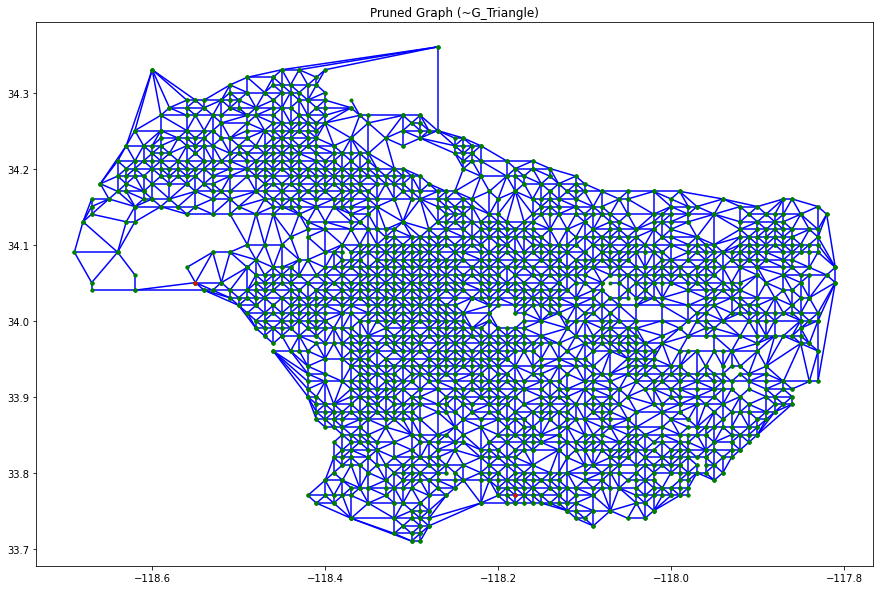

In [33]:
plt.figure(figsize=(15,10))
points=[]
for edges in graph_triangled_thresh.keys():
    coords1 = get_mean_coordinate(str(edges[0]))
    coords2 = get_mean_coordinate(str(edges[1]))
    points.append(coords1)
    points.append(coords2)
    plt.plot([coords1[0],coords2[0]],[coords1[1],coords2[1]],color='b')
points_thresh_arr = np.array(points)  
plt.plot(points_thresh_arr[:,0], points_thresh_arr[:,1], 'g.')

plt.plot(malibu_coor[0], malibu_coor[1], 'r.')
plt.plot(long_beach_coor[0], long_beach_coor[1], 'r.')
plt.title('Pruned Graph (~G_Triangle)')
plt.show()


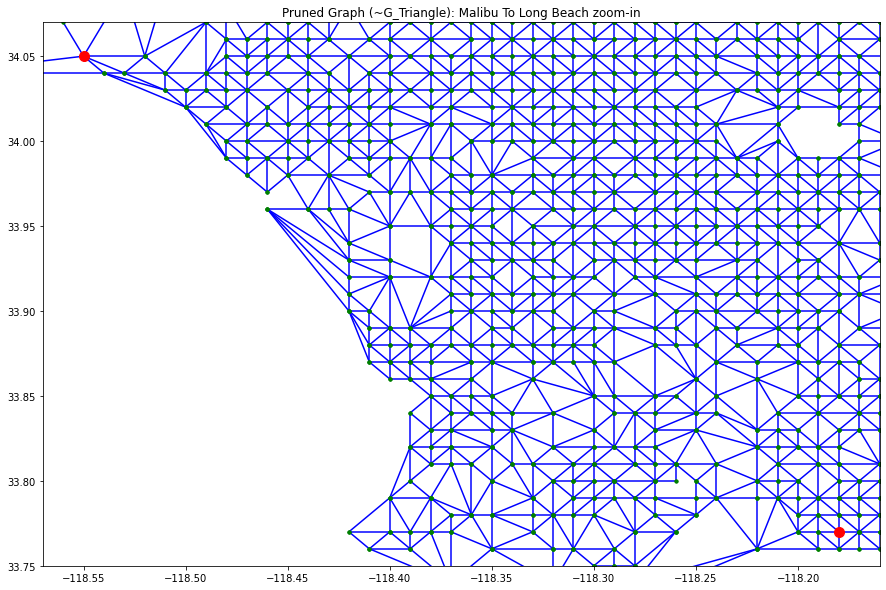

In [34]:
plt.figure(figsize=(15,10))
points=[]
for edges in graph_triangled_thresh.keys():
    coords1 = get_mean_coordinate(str(edges[0]))
    coords2 = get_mean_coordinate(str(edges[1]))
    points.append(coords1)
    points.append(coords2)
    plt.plot([coords1[0],coords2[0]],[coords1[1],coords2[1]],color='b')
points_thresh_arr = np.array(points)  
plt.plot(points_thresh_arr[:,0], points_thresh_arr[:,1], 'g.')

plt.plot(malibu_coor[0], malibu_coor[1], 'r.', ms=20)
plt.plot(long_beach_coor[0], long_beach_coor[1], 'r.', ms=20)

plt.xlim(malibu_coor[0]-0.02, long_beach_coor[0]+0.02)
plt.ylim(long_beach_coor[1]-0.02, malibu_coor[1]+0.02)

plt.title('Pruned Graph (~G_Triangle): Malibu To Long Beach zoom-in')

plt.show()


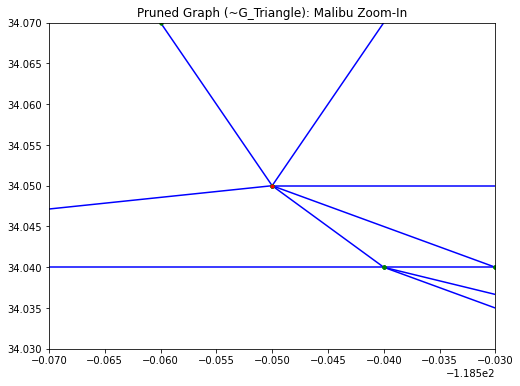

In [35]:
plt.figure(figsize=(8,6))
points=[]
for edges in graph_triangled_thresh.keys():
    coords1 = get_mean_coordinate(str(edges[0]))
    coords2 = get_mean_coordinate(str(edges[1]))
    points.append(coords1)
    points.append(coords2)
    plt.plot([coords1[0],coords2[0]],[coords1[1],coords2[1]],color='b')
points_thresh_arr = np.array(points)  
plt.plot(points_thresh_arr[:,0], points_thresh_arr[:,1], 'g.')

plt.plot(malibu_coor[0], malibu_coor[1], 'r.')
# plt.plot(long_beach_coor[0], long_beach_coor[1], 'r.')
plt.xlim((malibu_coor[0]-0.02,malibu_coor[0]+0.02))
plt.ylim((malibu_coor[1]-0.02,malibu_coor[1]+0.02))

plt.title('Pruned Graph (~G_Triangle): Malibu Zoom-In')

plt.show()


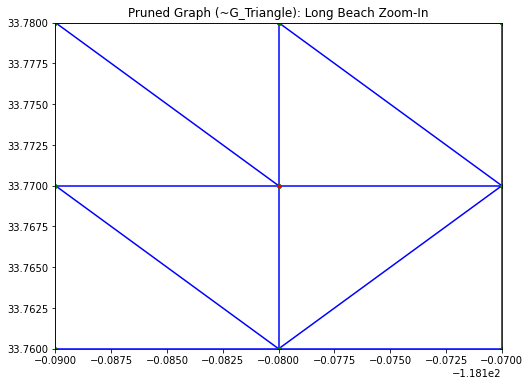

In [36]:
plt.figure(figsize=(8,6))
points=[]
for edges in graph_triangled_thresh.keys():
    coords1 = get_mean_coordinate(str(edges[0]))
    coords2 = get_mean_coordinate(str(edges[1]))
    points.append(coords1)
    points.append(coords2)
    plt.plot([coords1[0],coords2[0]],[coords1[1],coords2[1]],color='b')
points_thresh_arr = np.array(points)  
plt.plot(points_thresh_arr[:,0], points_thresh_arr[:,1], 'g.')

plt.plot(long_beach_coor[0], long_beach_coor[1], 'r.')
plt.xlim((long_beach_coor[0]-0.01,long_beach_coor[0]+0.01))
plt.ylim((long_beach_coor[1]-0.01,long_beach_coor[1]+0.01))

plt.title('Pruned Graph (~G_Triangle): Long Beach Zoom-In')
plt.show()

In [37]:
len(graph_triangled_thresh)

5369

# TESTING